# The `analosis` package: an example

**Authors**: Natalie B. Hogg, Pierre Fleury

The `analosis` (`analysis` + `los`) package allows us to perform various analyses of the line-of-sight effects using `lenstronomy` while maintaining the same settings across the board. 

**Warning**: in reality this means many parameter choices are hard-coded inside `analosis`. 

This notebook provides an example of how to use `analosis`, allowing you to choose what type of lensing scenario to analyse and to save the results to your machine.

In [1]:
# set the path to analosis relative to this notebook
import sys
sys.path.append('../..')

# import the Run class which allows you to run the analysis of your choice
from analosis.run import Run

/home/natalie/anaconda3/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


### Cosmology
We firstly set up the cosmology. The `id` needs to match one of the cosmologies available in the colossus package: https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html#standard-cosmologies.

In [2]:
cosmology = {'id': 'planck18', 'H0': 67.4, 'Om': 0.315}

### Image settings
We now impose the settings used to generate the images.
* `generate_image`: can be True or False. If true, generates a new set of images and associated data. If false, looks for pre-existing image data with the name you passed, which can be plotted or fit with the MCMC.
* `number_of_images`: the number of images you want to generate or analyse. For analysing pre-generated images, this setting is ignored.
* `image_name`: the name under which the image files will be saved
* `lens_light`: True or False. Whether or not to add lens light to the image. If lens light is present, it is automatically fit by the MCMC.
* `maximum_shear`: the maximum value the LOS shears can take
* `Einstein_radius_min`: the minimum allowed Einstein radius in arcsecs
* `min_aspect_ratio_*`: the minimum aspect ratio for the source, baryon and halo ellipticities
* `maximum_source_offset_factor`: the maximum value for the offset of the source from the centre of the image
* `max_source_perturbations`: maximum number of additional Sersic profiles added to simulate a perturbed source
* `fixed_numpix`: True or False. Whether to fix the number of pixels in an image or scale the image size with the Einstein ring
* `sigma_halo_offset`: the offset of the halo from the baryonic part of the lens in parsecs

In [3]:
image_settings = {'generate_image': True,
                  'number_of_images': 64,
                  'image_name': 'test_job',
                  'lens_light': True,
                  'maximum_shear': 0.025, # any larger means gamma_LOS > 0.05 which is challenging for the MCMC
                  'Einstein_radius_min': 0.5, # arcsec
                  'min_aspect_ratio_source': 0.7,
                  'min_aspect_ratio_baryons': 0.7,
                  'min_aspect_ratio_nfw': 0.7,
                  'maximum_source_offset_factor': 0.3, # in units of Einstein radius
                  'max_source_perturbations': 3, # 3 additional Sersics with amplitudes that are randomly 0-5% of the main source
                  'fixed_numpix': False,
                  'sigma_halo_offset': 300} # pc 

### MCMC settings
Here we impose the settings for the MCMC analysis.
* `MCMC`: can be True or False. If true, an MCMC analysis on the data with the given job name will be run. If false, it will not.
* `complexity`: the model you want to use to fit the images that you generated (all models are generated using the full LOS model with three shears). The options are: `perfect_minimal`, `perfect`, `missing_offset`, `missing_foreground_shear`, `missing_halo_ellipticity` and `power_law`. Other fitting models can be easily implemented in the MCMC class of `analosis`.
* `number_of_runs`: how many MCMCs you want to run on the set of images (must be smaller than the number of images in your dataset)
* `starting_index`: the numbering system for your saved chain files. Zero by default, but you can set a higher number if you want to re-use a job name without overwriting that job's previous chains.
* `sampler`: potentially any sampler available in `lenstronomy`, but at the moment `analosis` is only set up to use `EMCEE` or `ZEUS`
* `job_name`: the name under which the chain files will be saved. use something descriptive!
* `n_burn`: number of burn-in steps for the MCMC
* `n_run`: number of sampling steps for the MCMC

In [4]:
mcmc_settings = {'MCMC': False, 
                 'complexity': 'perfect_minimal',
                 'number_of_runs': 3, 
                 'starting_index': 0, 
                 'sampler': 'EMCEE', 
                 'job_name': 'my_job', 
                 'n_burn': 500, 
                 'n_run': 500} 

### Run
Now run the code. The results are automatically saved in the results folder provided by `analosis`.

In [5]:
result = Run(cosmology, image_settings, mcmc_settings)

Adding between 1 and 3 source perturbations per image.
MCMC will not be run.

Analysis complete and results saved at /home/natalie/Projects/analosis_ssh/analosis/results.


### Get the path

The Run class returns the path to where the results are saved, but you can pass any path you want to the subsequent plotting functions, if you decide to move the data elsewhere.

In [6]:
path = result.pathfinder()

### Import the Plots class

In [7]:
from analosis.analysis.plots import Plots
p = Plots(cosmology, path)

### Image plot

Preparing image plot...


/home/natalie/Projects/analosis_ssh/analosis/notebooks/../../analosis/analysis/plots.py:116: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_list[n]), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


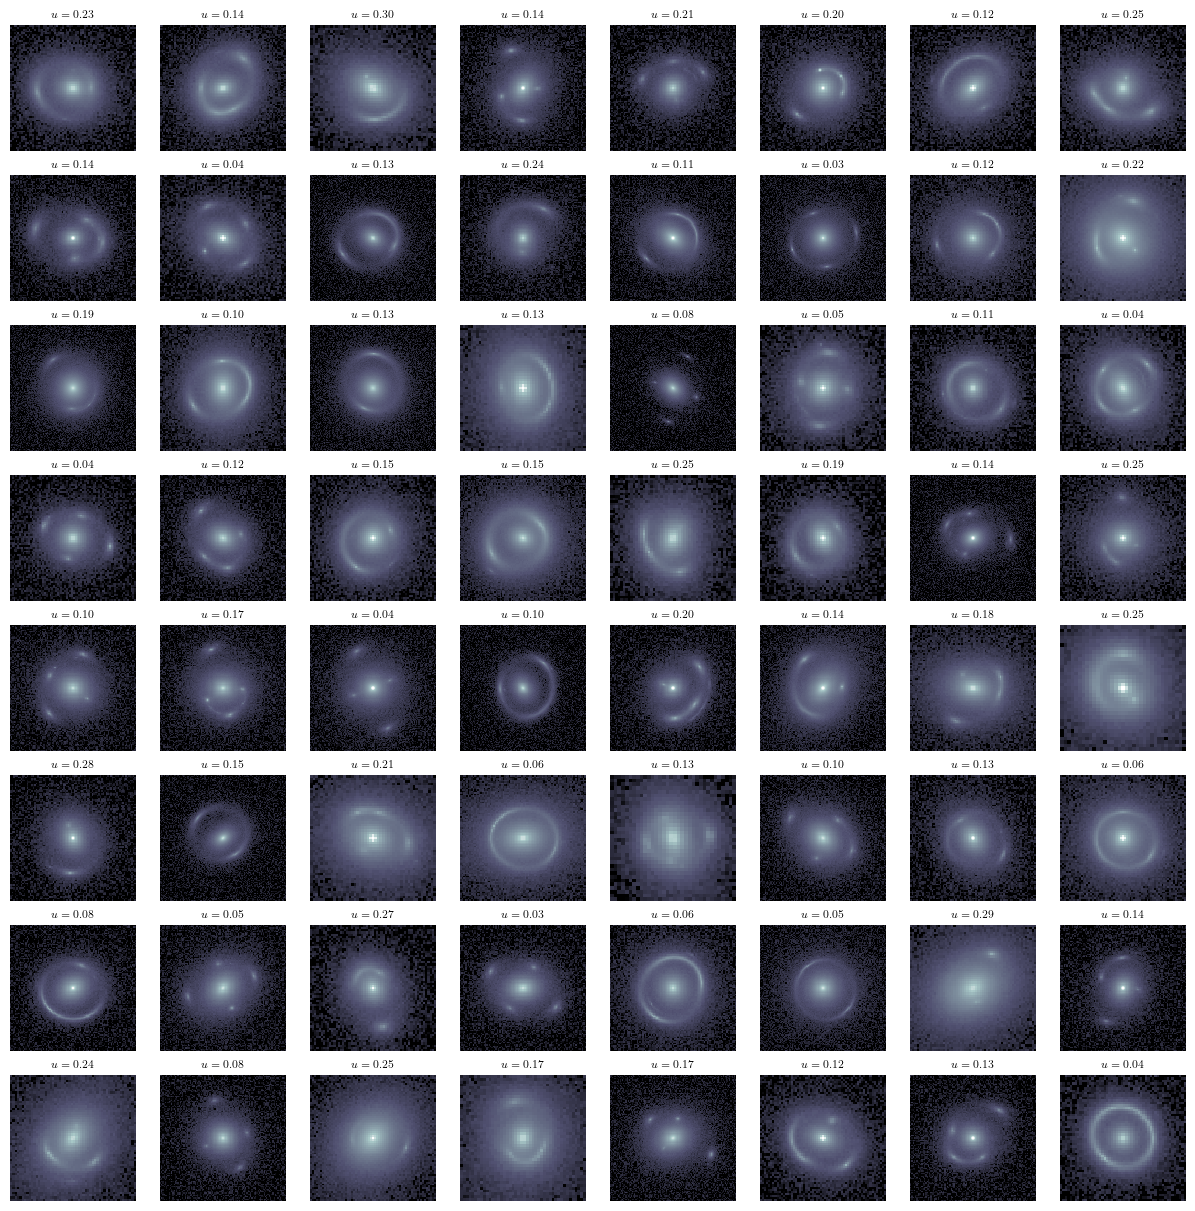

In [8]:
p.image_plot(path, image_settings, number_of_columns=8, u_max=10, save=True, show=True)

### Input vs output plot
Have a look at the input LOS shear vs the value found by the MCMC. Open circles show unconstrained parameters. To improve the convergence, you can run longer chains. The colour bar corresponds to the image quality (the darker the better).

In [ ]:
p.input_output_plot(path, image_settings, mcmc_settings, b_max = None, show_not_converged=True, use_colourmap=True, save=True, show=True)

### Contour plot
You can plot one chain at a time, and there are separate functions for plotting from chains produced by `emcee` or `zeus`. The chain files are named like `<job_name>_0.h5`, `<job_name>_1.h5` etc. Set the `chain_number` to the number of the chain you want to plot. You can pass the parameters you want to plot too, as a list of strings. To get an idea what all the parameters are called, you can look at the `<image_name>_input_kwargs.csv` file that is saved with your results.

In [ ]:
chain_number = 2
plot_params = ['gamma1_los', 'gamma2_los']
size = (6,6)
p.emcee_contour_plot(path, image_settings, mcmc_settings, chain_number, plot_params, size, draft=False, save=True, show=True)